In [ ]:
# The script below uses the output from webcam_cart_floorplane_calibration
# to directly project the square into the floor plane
# (It could be run in a script to make it easier)

In [46]:
import numpy as np
import cv2

imageSize = (640, 480)
cameraMatrix = np.\
array([[1.46536470e+03, 0.00000000e+00, 2.41959708e+02],
       [0.00000000e+00, 1.46536470e+03, 3.98210895e+02],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])
distCoeffs = np.array([[ 1.24767578e-01,  1.05001101e+01,  3.51748275e-02,
        -7.35526444e-03,  1.24203812e+03]])
markerLength = 0.080  # dimension in metres

plane0 = np.array([0.4150638 , 0.09830259, 1.46671931])
planeX = np.array([-0.05775419, -0.82797921,  0.55777672])
planeY = np.array([-0.99033931, -0.02303593, -0.13673844])
planeZ = np.array([ 0.1260655 , -0.56028543, -0.81864994])
dot0Z = sum(plane0*planeZ)

def projecttofloorplane(iu, iv):
    cu, cv = cv2.undistortPoints(np.array([iu, iv]), cameraMatrix, distCoeffs)[0][0]
    # Solve (cu*k, cv*k, k) . planeZ = dot0Z 
    k = dot0Z / sum(planeZ*np.array([cu, cv, 1]))
    p = np.array([cu*k, cv*k, k])
    pu = sum((p - plane0)*planeX)
    pv = sum((p - plane0)*planeY)
    return pu, pv

def cornersprojecttofloorplane(corners):
    cuvs = cv2.undistortPoints(corners, cameraMatrix, distCoeffs)
    puvs = [ ]
    for cuv in cuvs:
        cu, cv = cuv[0]
        # Solve (cu*k, cv*k, k) . planeZ = dot0Z 
        k = dot0Z / sum(planeZ*np.array([cu, cv, 1]))
        p = np.array([cu*k, cv*k, k])
        pu = sum((p - plane0)*planeX)
        pv = sum((p - plane0)*planeY)
        puvs.append([pu, pv])
    return puvs


In [47]:
import numpy as np
import cv2, json, math, time
import paho.mqtt.client as mqtt

arucocartkey = "aruco3"

client = mqtt.Client("miniwheels1")
client.connect("sensorcity.io")

winSize, zeroZone, criteria = (5, 5), (-1, -1), (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_COUNT, 30, 0.1)

aruco_dict = cv2.aruco.Dictionary_get(cv2.aruco.DICT_4X4_50)
parameters =  cv2.aruco.DetectorParameters_create()
cap = cv2.VideoCapture(2)  # works on webcam plugged in
cap.set(cv2.CAP_PROP_SHARPNESS, 1)
cap.set(cv2.CAP_PROP_BRIGHTNESS, 80)

aruco_dict = cv2.aruco.Dictionary_get(cv2.aruco.DICT_4X4_50)
parameters =  cv2.aruco.DetectorParameters_create()
while(True):
    if not cap.grab():
        time.sleep(0.01)
        continue

    ret, frame = cap.read()
    gframe = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    corners, ids, rejectedImgPoints = cv2.aruco.detectMarkers(frame, aruco_dict, parameters=parameters)
    puvs = None
    for i in range(len(ids) if ids is not None else 0):
        key = "aruco%d"%ids[i][0]
        if key == arucocartkey:
            cv2.cornerSubPix(gframe, corners[0], winSize, zeroZone, criteria)
            puvs = cornersprojecttofloorplane(corners[0])
            break
    if puvs is not None:
        xC = sum(X[0]  for X in puvs)/4
        yC = sum(X[1]  for X in puvs)/4
        vx = puvs[0][0] - xC
        vy = puvs[0][1] - yC
        theta = math.degrees(math.atan2(vx, vy)) + 45
        
        res = {"theta":(theta+360)%360, "x":xC, "y":yC }
        client.publish("miniwheels1/jppos", json.dumps(res))

cap.release()


KeyboardInterrupt: 

In [48]:
cap.release()


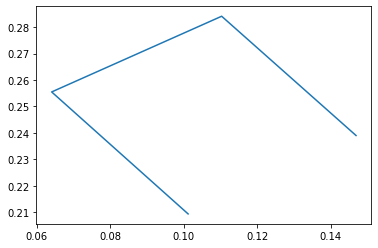

In [35]:
from matplotlib import pyplot as plt
%matplotlib inline


In [19]:
cv2.undistortPoints(corners[0], cameraMatrix, distCoeffs)


array([[[-0.01530666, -0.09315329]],

       [[ 0.01478926, -0.09534159]],

       [[ 0.01930351, -0.06898478]],

       [[-0.01391981, -0.06655851]]], dtype=float32)

In [23]:
cuvs = cv2.undistortPoints(corners[0], cameraMatrix, distCoeffs)
for cuv in cuvs:
    print(cuv)

[[-0.01530666 -0.09315329]]
[[ 0.01478926 -0.09534159]]
[[ 0.01930351 -0.06898478]]
[[-0.01391981 -0.06655851]]


[[0.283064301831845, 0.4268129287596514],
 [0.2897291928271939, 0.3786730387686836],
 [0.2372442183308719, 0.3751086276921354],
 [0.23037587366502463, 0.4272782809845356]]

In [12]:
cv2.cornerSubPix(gframe, corners[0], winSize, zeroZone, criteria)


array([[[219.51239, 262.6449 ],
        [263.44757, 259.51862],
        [270.07645, 297.79718],
        [221.58476, 301.2633 ]]], dtype=float32)

In [13]:
corners[0]

array([[[219.51239, 262.6449 ],
        [263.44757, 259.51862],
        [270.07645, 297.79718],
        [221.58476, 301.2633 ]]], dtype=float32)

In [ ]:
# Old version which did the projections directly! (and was unreliable)
import numpy as np
import cv2, json, math
import paho.mqtt.client as mqtt

arucocartkey = "aruco3"

client = mqtt.Client("miniwheels1")
client.connect("sensorcity.io")

winSize, zeroZone, criteria = (5, 5), (-1, -1), (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_COUNT, 30, 0.1)

aruco_dict = cv2.aruco.Dictionary_get(cv2.aruco.DICT_4X4_50)
parameters =  cv2.aruco.DetectorParameters_create()
cap = cv2.VideoCapture(1)  # works on webcam plugged in
cap.set(cv2.CAP_PROP_SHARPNESS, 1)
cap.set(cv2.CAP_PROP_BRIGHTNESS, 80)

aruco_dict = cv2.aruco.Dictionary_get(cv2.aruco.DICT_4X4_50)
parameters =  cv2.aruco.DetectorParameters_create()
while(True):
    ret, frame = cap.read()
    gframe = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    corners, ids, rejectedImgPoints = cv2.aruco.detectMarkers(frame, aruco_dict, parameters=parameters)
    for corner in corners:
        cv2.cornerSubPix(gframe, corner, winSize, zeroZone, criteria)
    #crvecs, ctvecs, _objPoints = cv2.aruco.estimatePoseSingleMarkers(corners, markerLength, cameraMatrix, distCoeffs)
    res = {}
    for i in range(len(ids) if ids is not None else 0):
        m = cv2.Rodrigues(crvecs[i])[0]
        theta = math.degrees(math.atan2(m[1][0], m[1][1]))
        res["aruco%d"%ids[i][0]] = {"theta":theta, "tvec":list(ctvecs[i][0]) }
    client.publish("miniwheels1/jrpos", json.dumps(res))